# Runge Kutta Method


## The Nystrome Scheme
$$
C = (0,\frac{2}{3})
$$

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def NYSolver(f,t,y0,h):
    A = np.array([[0,0,0],[2/3,0,0],[0,2/3,0]])
    c = np.array([0,2/3,2/3])
    b = np.array([1/4,3/8,3/8])
    y = np.array([y0])
    
    for tn in t:
        n = np.where(t==tn)[0][0]
        #Clculation of Ei values
        E = np.array([])
        for i in range(len(c)):
            s = 0
            for j in range(i):
                #print(f"({i},{j})")
                #print(A[i][j])
                s += h*A[i][j]*f(tn+c[j]*h,E[j])
            En = y[n] + s
            E = np.append(E,En)

        #print(E)
        #print(y)
        #Calculating the next step
        s=0
        for i in range(len(b)):
            s+=h*b[i]*f(tn+c[i]*h,E[i])
        yns = y[n] + s
        y = np.append(y,yns)

    return y[:-1]


In [3]:
h = 1e-4
t = np.arange(0,10,h)
def f(t,y):
    return -y + 2*np.exp(-t)*np.cos(2*t)

soln = NYSolver(f,t,0,h)

def yExact(t):
    soln = np.exp(-t)*np.sin(2*t)
    return soln

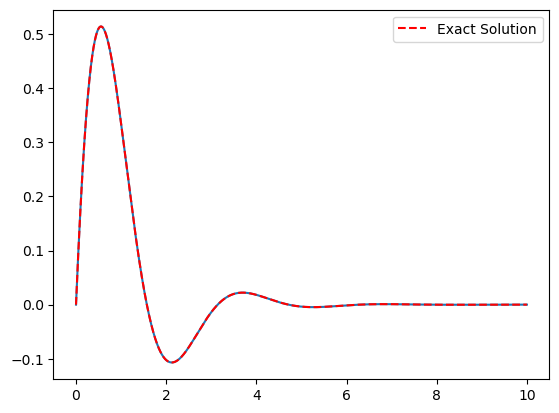

In [4]:
plt.plot(t,soln)
plt.plot(t,yExact(t),"r--",label="Exact Solution")
plt.legend()
plt.show()

230
[ 0.00000000e+00 -1.47993597e-17 -2.96529294e-17 ... -2.63596653e-18
 -2.63596653e-18 -2.63596653e-18]


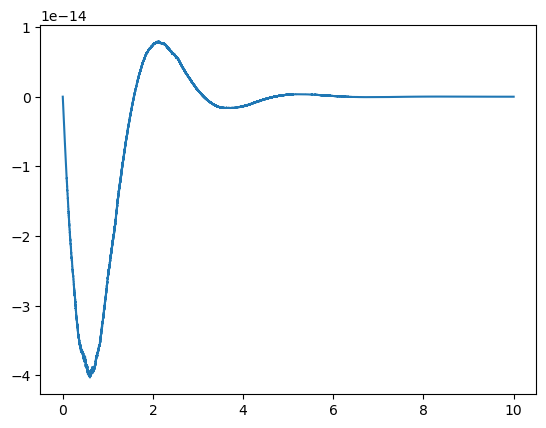

In [5]:
errorNY = yExact(t)-soln

plt.plot(t,errorNY)
count = 0
for n in range(3,len(errorNY)-2):
    if errorNY[n]<0 and errorNY[n+1]>0 :
        count+=1
    elif errorNY[n]>0 and errorNY[n+1]<0:
        count+=1
print(count)
print(errorNY)


Take the largest local eroor, then divide it to h. Then its order will be something like $10^{-(p+1)}$. Then calculate the order, $p$. 
This is not working because as h gets smaller and smaller, the contribution of the other orther becomes non-negligable I guess.

In [6]:
error = abs(yExact(t)-soln)
Max = max(np.log(error))
print(Max/np.log(h))

3.3486707862887233


/tmp/ipykernel_18635/883983110.py:2: RuntimeWarning: divide by zero encountered in log
  Max = max(np.log(error))


 ## Collocation Runge-Kutta Schemes
 One can reach the greatest order of a collocation scheme with the roots of orthogonal polynomials with respect to $w(t)=1$ in the region $t \in [0,1]$. One candidate of these polynomials is the Legendre Polynomials. However, legendre polynomials are orthogonal in the region [-1,1]. Hence, they need to be linearly transformed, so that all of the roots will be in the region [0,1] because we want our R-K nodes to be in that region. A monic transformed form of the legendre polynomials is
 $$
P_n(t) = \frac{(n!)^2}{(2n)!} \sum_{k=0}^n {n \choose k}{n+k \choose k}t^k
 $$ 
 Then if we choose our nodes as roots of the nth legendre polynomial $P_n(t)$, we will obtain a runge kutta scheme which has order of 2n by collocation.

[0.21132487 0.78867513]


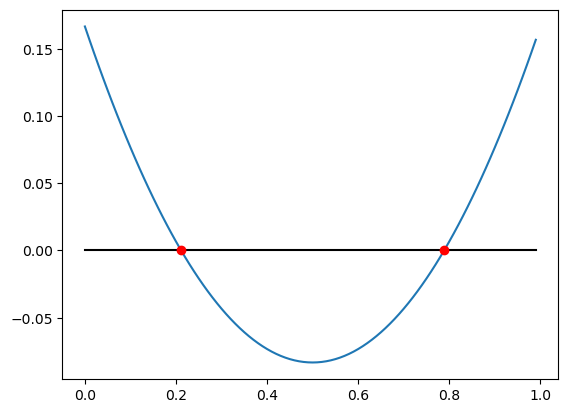

In [7]:
def leg(n,t,i="none"):
    p = sp.special.legendre(n, monic=True)
    P=1
    roots = (p.roots+1)/2 #Transforming the roots into the region [0,1]. 
    roots = roots[::-1]
    if i == "none":
        
        for r in roots:
            P*=(t-r)

        return np.array(P), roots
    else:
        roots = np.delete(roots,i)
        for r in roots:
            #print(roots)
            P*=(t-r)
        return np.array(P), roots
        
t = np.arange(0,1,0.01)
n = 2
P = leg(n,t)
print(P[1])
plt.plot(t,np.zeros_like(t),"k")
plt.plot(t,P[0])
plt.plot(P[1],np.zeros_like(P[1]),"ro")

plt.show()


In [8]:
0.5+np.sqrt(3)/6


0.7886751345948129

## Calculating the Scheme Using Collocation
$$
a_{j,i} = \int_0^{c_j} \frac{q_i(t)}{q_i{c_i}} dt 
$$
and
$$
b_j = \int_0^{1} \frac{q_j(t)}{q_j{c_j}} dt
$$

In [9]:
def schemCal(n,t):
    A = np.zeros((n,n))
    P = leg(n,t)
    c = P[1]
    b = np.zeros_like(c)
    def q(t,i):
        qi = leg(n,t,i)[0]
        qc = leg(n,c[i],i)[0]
        return qi/qc
    for j in range(len(c)):
        for i in range(len(c)):
            A[j][i] = sp.integrate.quad(q,0,c[j],args=(i))[0]
        b[j] = sp.integrate.quad(q,0,1,args=(j))[0]
    return c,b,A
schem=schemCal(2,t)
print(f"{schem[0]}\n{schem[1]}\n{schem[2]}\n")

[0.21132487 0.78867513]
[0.5 0.5]
[[ 0.25       -0.03867513]
 [ 0.53867513  0.25      ]]



In [10]:
a = np.array([1,2,3,4,5])
np.delete(a,0)

array([2, 3, 4, 5])

In [11]:
def legRK(f,t,y_0,h,n,args="none"):
    scheme = schemCal(n,t)
    c = scheme[0]
    b = scheme[1]
    A = scheme[2]
    y = np.array([y_0])
    for tn in t:
        l = np.where(t==tn)[0][0]
            #Clculation of Ei values
        E = np.array([])
        for i in range(len(c)):
            s = 0
            for j in range(i):
                    #print(f"({i},{j})")
                    #print(A[i][j])
                s += h*A[i][j]*f(tn+c[j]*h,E[j])
            En = y[l] + s
            E = np.append(E,En)

        #print(E)
        #print(y)
        #Calculating the next step
        s=0
        for i in range(len(b)):
            s+=h*b[i]*f(tn+c[i]*h,E[i])
        yns = y[l] + s
        y = np.append(y,yns)

    return y[:-1]



[]

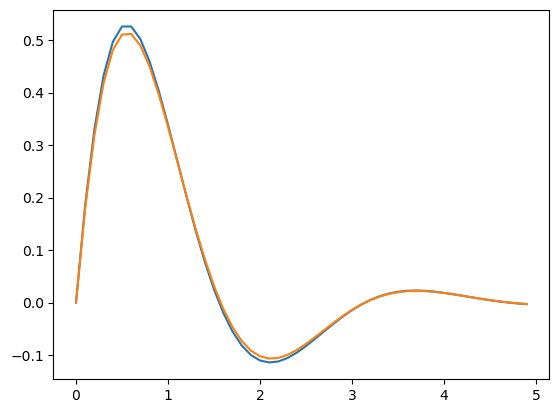

In [12]:
h = 1e-1
t = np.arange(0,5,h)
soln = legRK(f,t,0,h,5)
plt.plot(t,soln)
plt.plot(t,yExact(t))
plt.plot()

0.008995413691043841


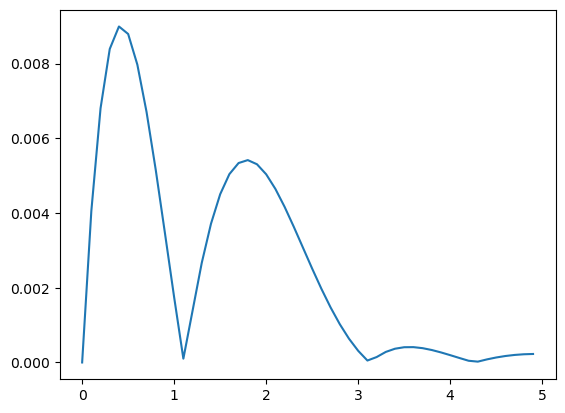

In [13]:
soln = legRK(f,t,0,h,2)
error = (abs(soln-yExact(t)))
plt.plot(t,error)
print(max(error))


## Error rate sequence
Consider the sequence
$$
\left\{\frac{e_{n+1}}{e_n}\right\}
$$
where $e_n = |y(t_n)-y_n|$

/tmp/ipykernel_18635/1572666985.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  r = R.append(en1/en**4)


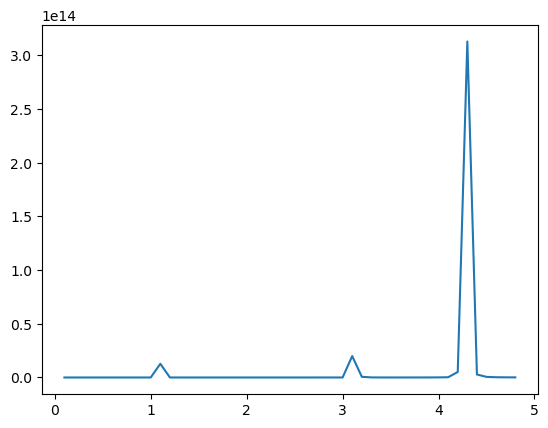

In [14]:
R = []
for n in range(1,len(t)):
    en1 = abs(yExact(t[n])-soln[n])
    en = abs(yExact(t[n-1])-soln[n-1])
    r = R.append(en1/en**4)
R = np.array(R)
plt.plot(t[:-1],R)

## Runge Kutta in vector form

In [15]:
def legRKV(f,t,y_0,h,n):
    scheme = schemCal(n,t)
    c = scheme[0]
    b = scheme[1]
    A = scheme[2]
    y = np.array([y_0])
    for tn in t:
        l = np.where(t==tn)[0][0]
            #Clculation of Ei values
        E = np.array([y_0])
        for i in range(len(c)):
            s = np.zeros(len(y_0))
            for j in range(i):
                    #print(f"({i},{j})")
                    #print(A[i][j])
                #print(E)
                s += h*A[i][j]*f(tn+c[j]*h,E[j])
            En = y[l] + s
            #print(En)
            E = np.r_[E,[En]]
        
        #print(E)
        #print(E)
        #print(y)
        #Calculating the next step
        s=np.zeros(len(y_0))
        for i in range(len(b)):
            s+=h*b[i]*f(tn+c[i]*h,E[i])
        yns = y[l] + s
        y = np.r_[y,[yns]]

    return y[:-1]



## Lorenz Attroctor
$$
\dot{x} = \sigma (y-x)
$$
$$
\dot{y} = x(\rho-z) - y 
$$
$$
\dot{z} = xy - \beta z
$$

In [16]:
sig =10
rho = 28
beta = 8/3
def fx(t,y):
    dx = sig*(y[1]-y[2])
    dy = y[0]*(rho-y[2])-y[1]
    dz = y[0]*y[1]-beta*y[2]
    return np.array([dx,dy,dz])

soln = legRKV(fx,t,[1,0,0],h,3)

/tmp/ipykernel_18635/748622091.py:6: RuntimeWarning: overflow encountered in double_scalars
  dy = y[0]*(rho-y[2])-y[1]
/tmp/ipykernel_18635/748622091.py:7: RuntimeWarning: overflow encountered in double_scalars
  dz = y[0]*y[1]-beta*y[2]
/tmp/ipykernel_18635/748622091.py:7: RuntimeWarning: invalid value encountered in double_scalars
  dz = y[0]*y[1]-beta*y[2]
/tmp/ipykernel_18635/101115628.py:18: RuntimeWarning: invalid value encountered in add
  En = y[l] + s
/tmp/ipykernel_18635/101115628.py:29: RuntimeWarning: invalid value encountered in add
  yns = y[l] + s


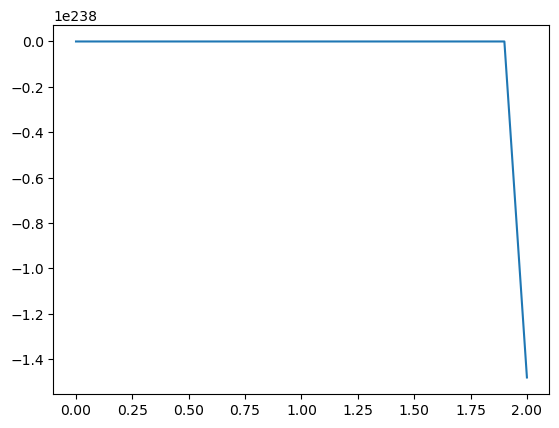

In [17]:
plt.plot(t,soln[:,2])

In [18]:
def legRKV(f,t,y_0,h,n):
    scheme = schemCal(n,t)
    c = scheme[0]
    b = scheme[1]
    A = scheme[2]
    y = np.array([y_0])
    for tn in t:
        l = np.where(t==tn)[0][0]
            #Clculation of Ei values
        E = np.array([y_0])
        for i in range(len(c)):
            s = np.zeros(len(y_0))
            for j in range(i):
                    #print(f"({i},{j})")
                    #print(A[i][j])
                #print(E)
                s += h*A[i][j]*f(tn+c[j]*h,E[j])
            En = y[l] + s
            #print(En)
            E = np.r_[E,[En]]
        
        #print(E)
        #print(E)
        #print(y)
        #Calculating the next step
        s=np.zeros(len(y_0))
        for i in range(len(b)):
            s+=h*b[i]*f(tn+c[i]*h,E[i])
        yns = y[l] + s
        y = np.r_[y,[yns]]

    return y[:-1]



/tmp/ipykernel_18635/3438142076.py:6: RuntimeWarning: overflow encountered in double_scalars
  dy = y[0]*(rho-y[2])-y[1]
/tmp/ipykernel_18635/3438142076.py:7: RuntimeWarning: overflow encountered in double_scalars
  dz = y[0]*y[1]-beta*y[2]
/tmp/ipykernel_18635/3438142076.py:6: RuntimeWarning: invalid value encountered in double_scalars
  dy = y[0]*(rho-y[2])-y[1]
/tmp/ipykernel_18635/101115628.py:18: RuntimeWarning: invalid value encountered in add
  En = y[l] + s
/tmp/ipykernel_18635/101115628.py:29: RuntimeWarning: invalid value encountered in add
  yns = y[l] + s


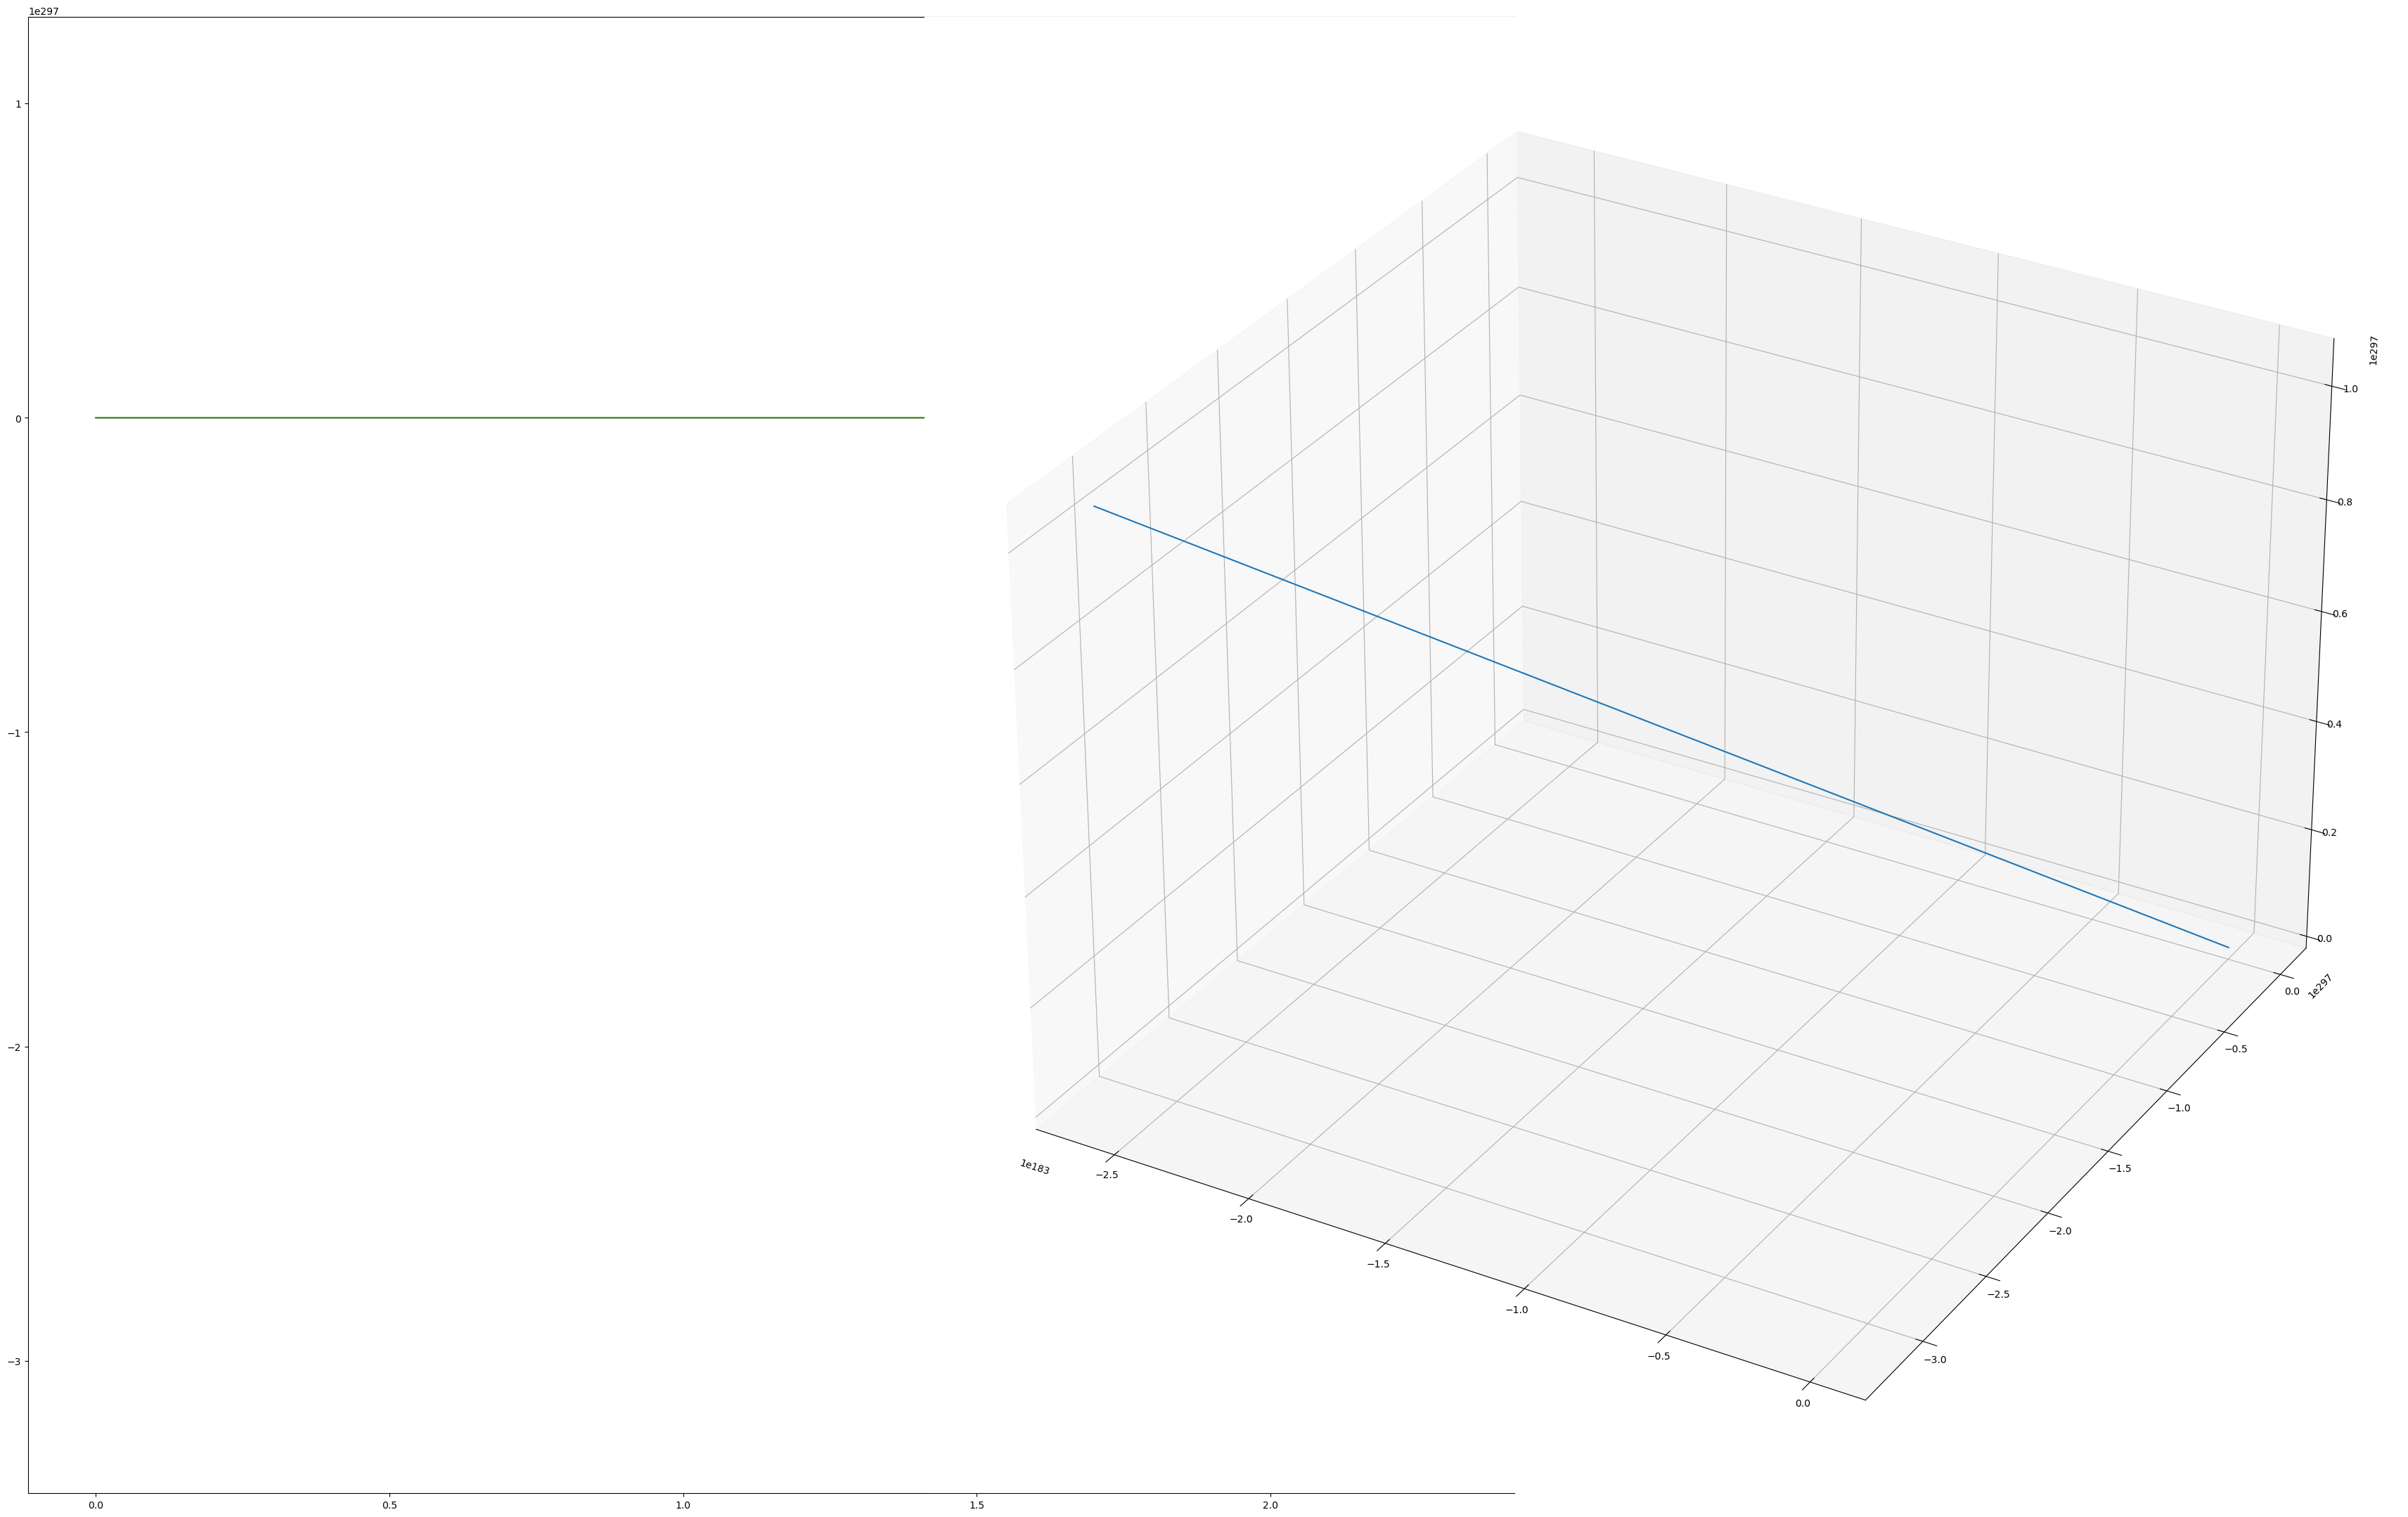

In [44]:
sig =10
rho = 28
beta = 8/3
def fx(t,y):
    dx = sig*(y[1]-y[0])
    dy = y[0]*(rho-y[2])-y[1]
    dz = y[0]*y[1]-beta*y[2]
    return np.array([dx,dy,dz])
y0 = [1,1,1]
h = 1e-1
t = np.arange(0,50,h)
solnRK = legRKV(fx,t,y0,h,3)

fig = plt.figure(figsize=(60,60))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,1,1,projection="3d")
for i in range(3):
    ax1.plot(t,solnRK[:,i])


ax2.plot(solnRK[:,0],solnRK[:,1],solnRK[:,2])


## $h=10^{-1}$ Case
In that case, there is something weird happens, the solution converges. Lorenz system has a chaotic behavour. This choice of the $h$ value is also works weird for one dimensional ODE above as well. At some points the error makes an incident jump. I believe, these jumps diverges the solution for such a chaotic system. For the lorenz system, when $\sigma =1$, $\rho = 1$,$\beta = 1$, and $h = 10^{-1}$ the solution converges something looks like a lorenz solution but not the real solution. For the choice of $\sigma =10$, $\rho = 28$,$\beta = \frac{8}{3}$, and $h = 10^{-1}$, the method diverges for $h = 10^{-1}$, but for the $h = 10^{-1}$.

Text(0.5, 0.92, 'h=1e-2')

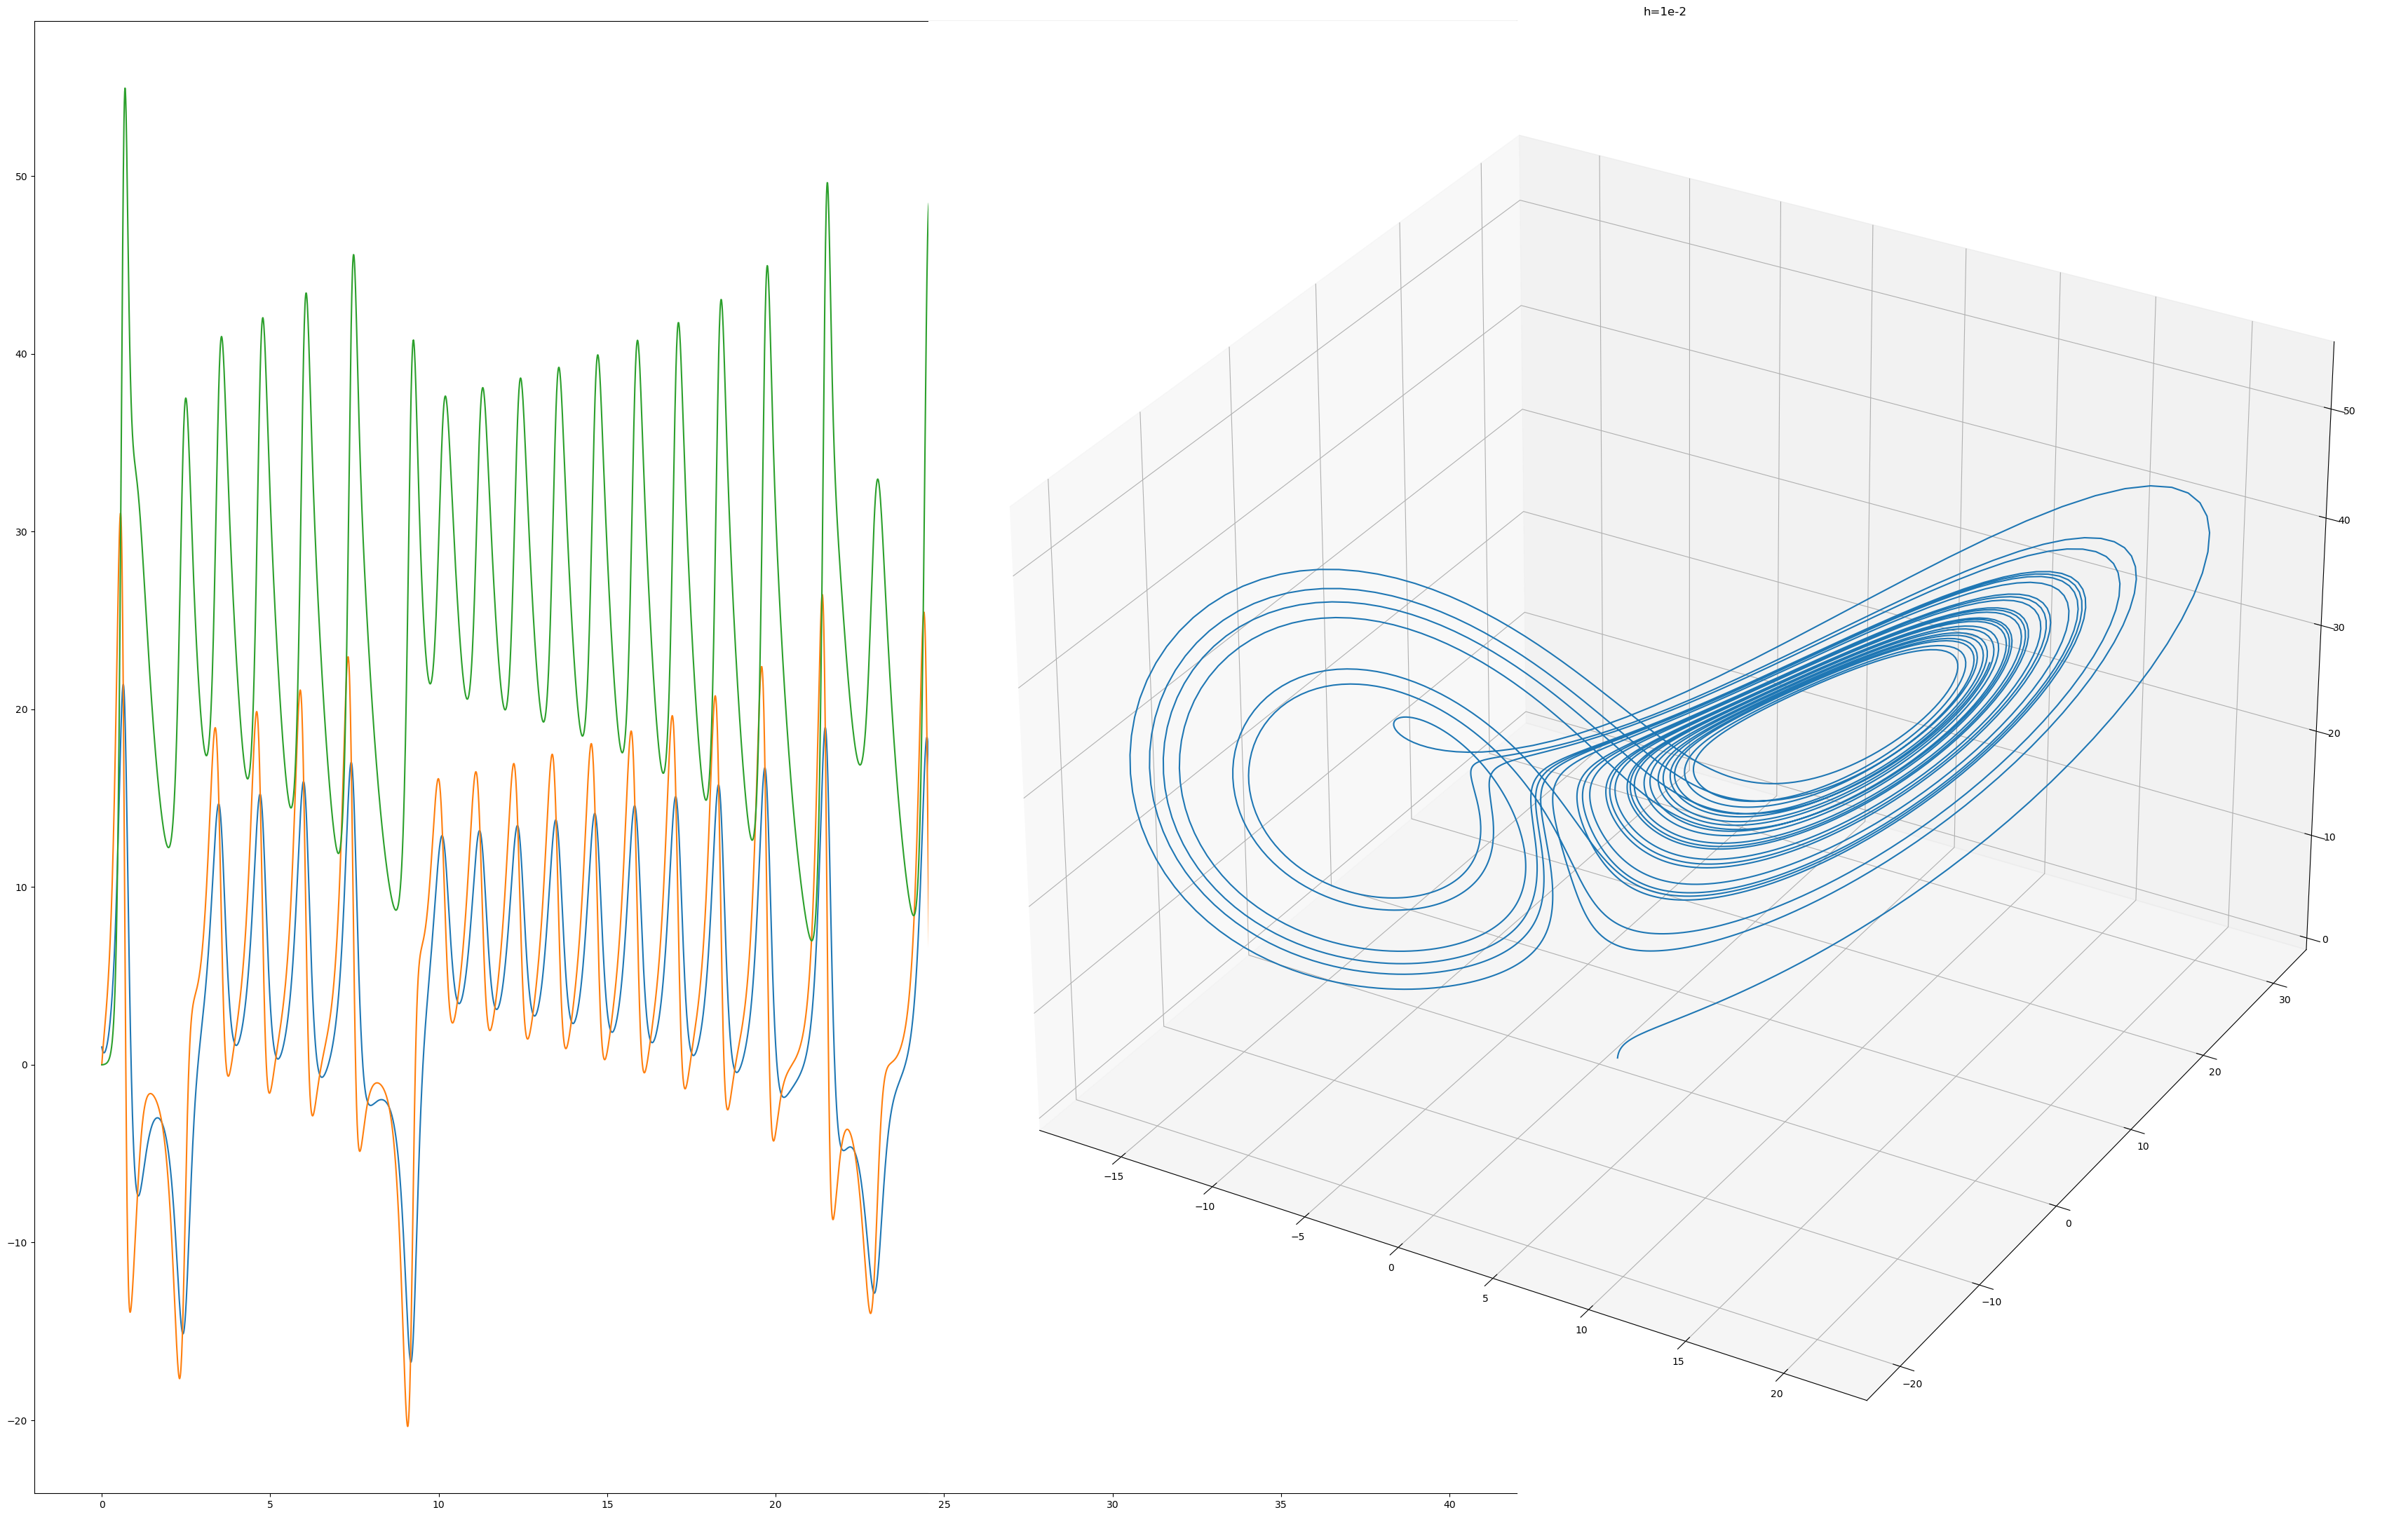

In [61]:
# h=1e-1
sig =10
rho = 28
beta = 8/3
def fx(t,y):
    dx = sig*(y[1]-y[0])
    dy = y[0]*(rho-y[2])-y[1]
    dz = y[0]*y[1]-beta*y[2]
    return np.array([dx,dy,dz])
y0 = [1,0,0]
h = 1e-2
t = np.arange(0,40,h)
solnRK = legRKV(fx,t,y0,h,3)

fig = plt.figure(figsize=(60,60))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,1,1,projection="3d")
for i in range(3):
    ax1.plot(t,solnRK[:,i])


ax2.plot(solnRK[:,0],solnRK[:,1],solnRK[:,2])
ax2.set_title("h=1e-2")

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 4790
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7fc4a2456160>
   status: 0
  success: True
        t: array([0.00000000e+00, 3.66301934e-02, 9.02042454e-02, 1.59230347e-01,
       2.58476675e-01, 3.16888157e-01, 3.75299640e-01, 4.22018904e-01,
       4.67356144e-01, 5.27170521e-01, 5.95496867e-01, 6.74863513e-01,
       7.58997761e-01, 8.63138557e-01, 9.89017206e-01, 1.11777480e+00,
       1.25402394e+00, 1.39526124e+00, 1.52781986e+00, 1.66037848e+00,
       1.78349561e+00, 1.90661274e+00, 2.05286940e+00, 2.18054374e+00,
       2.30786067e+00, 2.42803075e+00, 2.54820084e+00, 2.69276326e+00,
       2.81821597e+00, 2.94259414e+00, 3.06398352e+00, 3.18537290e+00,
       3.34208728e+00, 3.46822213e+00, 3.59164767e+00, 3.71895719e+00,
       3.84995592e+00, 3.99676479e+00, 4.13157781e+00, 4.24816935e+00,
       4.36476089e+00, 4.51426140e+00, 4.6379861

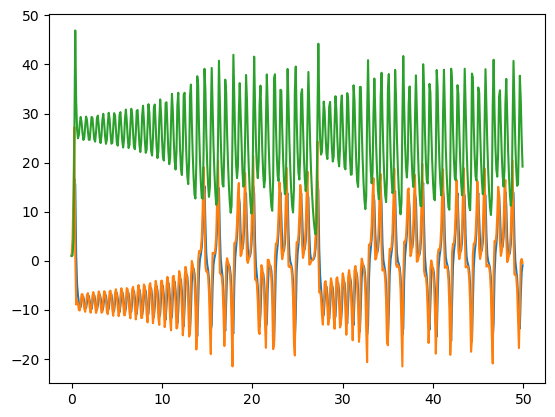

In [39]:
a = sp.integrate.solve_ivp(fx,(0,50),y0,dense_output=True)
soln = a.sol(t)
print(a)
for i in range(3):
    plt.plot(t,soln[i])
plt.show()

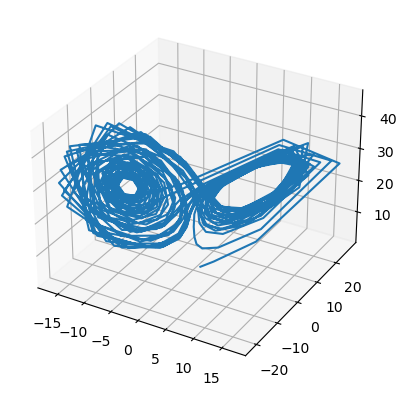

In [59]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(soln[0],soln[1],soln[2])